In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel*(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 512000)            0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3004 - acc: 0.3347
Epoch 00001: val_loss improved from inf to 1.61227, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_4_conv_checkpoint/001-1.6123.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.3004 - acc: 0.3347 - val_loss: 1.6123 - val_acc: 0.4864
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4975 - acc: 0.5365
Epoch 00002: val_loss improved from 1.61227 to 1.22746, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_4_conv_checkpoint/002-1.2275.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.4976 - acc: 0.5364 - val_loss: 1.2275 - val_acc: 0.6271
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2676 - acc: 0.6051
Epoch 00003: val_loss improved from 1.22746 to 1.20525, savin

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2598 - acc: 0.9136
Epoch 00027: val_loss did not improve from 0.97906
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2599 - acc: 0.9135 - val_loss: 1.0207 - val_acc: 0.7447
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2562 - acc: 0.9152
Epoch 00028: val_loss did not improve from 0.97906
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2562 - acc: 0.9152 - val_loss: 1.2113 - val_acc: 0.7126
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2400 - acc: 0.9209
Epoch 00029: val_loss did not improve from 0.97906
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2401 - acc: 0.9209 - val_loss: 1.0447 - val_acc: 0.7459
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2355 - acc: 0.9212
Epoch 00030: val_loss did not improve from 0.97906
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1301 - acc: 0.9579
Epoch 00057: val_loss did not improve from 0.97906
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1301 - acc: 0.9579 - val_loss: 1.0832 - val_acc: 0.7659
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1286 - acc: 0.9586
Epoch 00058: val_loss did not improve from 0.97906
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1287 - acc: 0.9586 - val_loss: 1.3578 - val_acc: 0.7263
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1324 - acc: 0.9579
Epoch 00059: val_loss did not improve from 0.97906
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1324 - acc: 0.9579 - val_loss: 1.4474 - val_acc: 0.6990
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1246 - acc: 0.9595
Epoch 00060: val_loss did not improve from 0.97906
36805/36805 [===========

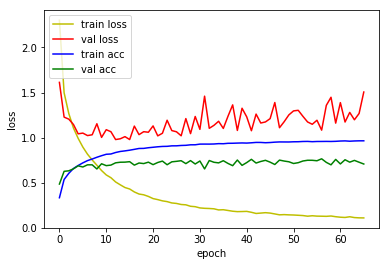

4815/4815 [==============================] - 2s 515us/sample - loss: 1.0876 - acc: 0.6982
Loss: 1.0876147106305338 Accuracy: 0.6982347

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2904 - acc: 0.3099
Epoch 00001: val_loss improved from inf to 1.73247, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_5_conv_checkpoint/001-1.7325.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.2904 - acc: 0.3100 - val_loss: 1.7325 - val_acc: 0.4349
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5022 - acc: 0.5246
Epoch 00002: val_loss improved from 1.73247 to 1.09685, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_5_conv_checkpoint/002-1.0968.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.5021 - acc: 0.5246 - val_loss: 1.0968 - val_acc: 0.6711
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4263 - acc: 0.8648
Epoch 00027: val_loss did not improve from 0.63387
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4264 - acc: 0.8647 - val_loss: 0.6557 - val_acc: 0.8171
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4096 - acc: 0.8732
Epoch 00028: val_loss did not improve from 0.63387
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4096 - acc: 0.8732 - val_loss: 0.6565 - val_acc: 0.8251
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3992 - acc: 0.8759
Epoch 00029: val_loss did not improve from 0.63387
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3991 - acc: 0.8759 - val_loss: 0.7023 - val_acc: 0.8041
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3864 - acc: 0.8786
Epoch 00030: val_loss did not improve from 0.63387
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.2378 - acc: 0.9239
Epoch 00056: val_loss did not improve from 0.60905
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2379 - acc: 0.9238 - val_loss: 0.7520 - val_acc: 0.8081
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2368 - acc: 0.9246
Epoch 00057: val_loss did not improve from 0.60905
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2368 - acc: 0.9246 - val_loss: 0.6760 - val_acc: 0.8164
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2346 - acc: 0.9251
Epoch 00058: val_loss did not improve from 0.60905
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2346 - acc: 0.9251 - val_loss: 0.6661 - val_acc: 0.8288
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2259 - acc: 0.9264
Epoch 00059: val_loss did not improve from 0.60905
36805/36805 [========================

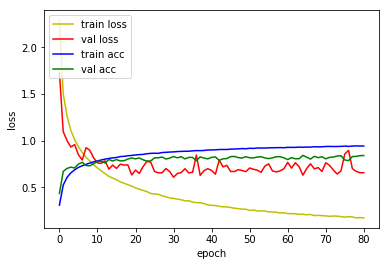

4815/4815 [==============================] - 3s 577us/sample - loss: 0.6712 - acc: 0.8027
Loss: 0.6712016487666256 Accuracy: 0.8026999

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4792 - acc: 0.2585
Epoch 00001: val_loss improved from inf to 1.84348, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_6_conv_checkpoint/001-1.8435.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.4791 - acc: 0.2585 - val_loss: 1.8435 - val_acc: 0.4004
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6365 - acc: 0.4802
Epoch 00002: val_loss improved from 1.84348 to 1.19238, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_6_conv_checkpoint/002-1.1924.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.6367 - acc: 0.4802 - val_loss: 1.1924 - val_acc: 0.6492
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4060 - acc: 0.8788
Epoch 00025: val_loss improved from 0.46150 to 0.42253, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_6_conv_checkpoint/025-0.4225.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4060 - acc: 0.8788 - val_loss: 0.4225 - val_acc: 0.8887
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3904 - acc: 0.8832
Epoch 00026: val_loss did not improve from 0.42253
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3905 - acc: 0.8832 - val_loss: 0.4598 - val_acc: 0.8726
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3885 - acc: 0.8837
Epoch 00027: val_loss did not improve from 0.42253
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3885 - acc: 0.8837 - val_loss: 0.4794 - val_acc: 0.8719
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.2468 - acc: 0.9244
Epoch 00053: val_loss did not improve from 0.38227
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2468 - acc: 0.9244 - val_loss: 0.5660 - val_acc: 0.8428
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2345 - acc: 0.9271
Epoch 00054: val_loss did not improve from 0.38227
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2347 - acc: 0.9270 - val_loss: 0.4072 - val_acc: 0.8875
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2327 - acc: 0.9274
Epoch 00055: val_loss did not improve from 0.38227
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2327 - acc: 0.9275 - val_loss: 0.3869 - val_acc: 0.8940
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2301 - acc: 0.9292
Epoch 00056: val_loss did not improve from 0.38227
36805/36805 [========================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1724 - acc: 0.9446
Epoch 00083: val_loss did not improve from 0.36839
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1724 - acc: 0.9446 - val_loss: 0.3718 - val_acc: 0.9017
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1642 - acc: 0.9468
Epoch 00084: val_loss did not improve from 0.36839
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1642 - acc: 0.9468 - val_loss: 0.5068 - val_acc: 0.8719
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1583 - acc: 0.9491
Epoch 00085: val_loss did not improve from 0.36839
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1583 - acc: 0.9491 - val_loss: 0.4499 - val_acc: 0.8884
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1585 - acc: 0.9504
Epoch 00086: val_loss did not improve from 0.36839
36805/36805 [===========

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1256 - acc: 0.9595
Epoch 00112: val_loss did not improve from 0.36154
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1256 - acc: 0.9595 - val_loss: 0.4095 - val_acc: 0.9036
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1222 - acc: 0.9600
Epoch 00113: val_loss did not improve from 0.36154
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1222 - acc: 0.9600 - val_loss: 0.3940 - val_acc: 0.9045
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1226 - acc: 0.9596
Epoch 00114: val_loss did not improve from 0.36154
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1226 - acc: 0.9596 - val_loss: 0.3729 - val_acc: 0.9106
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1170 - acc: 0.9620
Epoch 00115: val_loss did not improve from 0.36154
36805/36805 [=======

Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0950 - acc: 0.9700
Epoch 00142: val_loss did not improve from 0.36154
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0951 - acc: 0.9699 - val_loss: 0.4017 - val_acc: 0.8970
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0956 - acc: 0.9700
Epoch 00143: val_loss did not improve from 0.36154
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0956 - acc: 0.9700 - val_loss: 0.3930 - val_acc: 0.9110
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9707
Epoch 00144: val_loss did not improve from 0.36154
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0938 - acc: 0.9707 - val_loss: 0.4234 - val_acc: 0.9019
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9686
Epoch 00145: val_loss did not improve from 0.36154
36805/36805 [=======

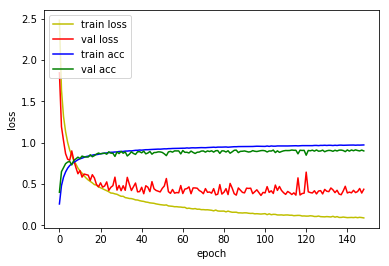

4815/4815 [==============================] - 3s 679us/sample - loss: 0.4524 - acc: 0.8739
Loss: 0.4524365982224513 Accuracy: 0.87393564

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4229 - acc: 0.2683
Epoch 00001: val_loss improved from inf to 1.68295, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_7_conv_checkpoint/001-1.6830.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.4228 - acc: 0.2683 - val_loss: 1.6830 - val_acc: 0.4705
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5310 - acc: 0.5089
Epoch 00002: val_loss improved from 1.68295 to 1.02013, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_7_conv_checkpoint/002-1.0201.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.5311 - acc: 0.5089 - val_loss: 1.0201 - val_acc: 0.7056
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2373 - acc: 0.9278
Epoch 00025: val_loss improved from 0.26683 to 0.25378, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_7_conv_checkpoint/025-0.2538.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2373 - acc: 0.9278 - val_loss: 0.2538 - val_acc: 0.9304
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2321 - acc: 0.9278
Epoch 00026: val_loss did not improve from 0.25378
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2321 - acc: 0.9278 - val_loss: 0.2702 - val_acc: 0.9231
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2237 - acc: 0.9318
Epoch 00027: val_loss improved from 0.25378 to 0.23117, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_7_conv_checkpoint/027-0.2312.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2239 - acc: 0.9317 - val_los

36800/36805 [============================>.] - ETA: 0s - loss: 0.1183 - acc: 0.9619
Epoch 00053: val_loss did not improve from 0.21742
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1183 - acc: 0.9619 - val_loss: 0.2271 - val_acc: 0.9436
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9639
Epoch 00054: val_loss did not improve from 0.21742
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1125 - acc: 0.9638 - val_loss: 0.2537 - val_acc: 0.9383
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9642
Epoch 00055: val_loss did not improve from 0.21742
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1116 - acc: 0.9642 - val_loss: 0.2261 - val_acc: 0.9450
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1116 - acc: 0.9640
Epoch 00056: val_loss did not improve from 0.21742
36805/36805 [========================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9762
Epoch 00083: val_loss did not improve from 0.21213
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0724 - acc: 0.9762 - val_loss: 0.2403 - val_acc: 0.9455
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9791
Epoch 00084: val_loss did not improve from 0.21213
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0671 - acc: 0.9791 - val_loss: 0.2642 - val_acc: 0.9378
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0763 - acc: 0.9759
Epoch 00085: val_loss did not improve from 0.21213
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0764 - acc: 0.9759 - val_loss: 0.2228 - val_acc: 0.9467
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9798
Epoch 00086: val_loss did not improve from 0.21213
36805/36805 [===========

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9846
Epoch 00113: val_loss did not improve from 0.21213
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0484 - acc: 0.9846 - val_loss: 0.2403 - val_acc: 0.9436
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9858
Epoch 00114: val_loss did not improve from 0.21213
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0447 - acc: 0.9858 - val_loss: 0.2807 - val_acc: 0.9399

1D_CNN_custom_3_ch_32_DO_BN_7_conv Model


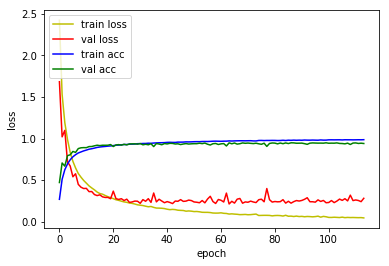

4815/4815 [==============================] - 3s 635us/sample - loss: 0.2709 - acc: 0.9242
Loss: 0.2708748114195692 Accuracy: 0.92419523

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4184 - acc: 0.2850
Epoch 00001: val_loss improved from inf to 1.70616, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_8_conv_checkpoint/001-1.7062.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 2.4183 - acc: 0.2850 - val_loss: 1.7062 - val_acc: 0.4570
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4345 - acc: 0.5390
Epoch 00002: val_loss improved from 1.70616 to 0.91074, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_8_conv_checkpoint/002-0.9107.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.4346 - acc: 0.5390 - val_loss: 0.9107 - val_acc: 0.7272
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1417 - acc: 0.9549
Epoch 00025: val_loss did not improve from 0.16972
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1418 - acc: 0.9548 - val_loss: 0.1893 - val_acc: 0.9492
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9562
Epoch 00026: val_loss did not improve from 0.16972
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1377 - acc: 0.9561 - val_loss: 0.1888 - val_acc: 0.9448
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1319 - acc: 0.9592
Epoch 00027: val_loss improved from 0.16972 to 0.15217, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_8_conv_checkpoint/027-0.1522.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1319 - acc: 0.9591 - val_loss: 0.1522 - val_acc: 0.9581
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9832
Epoch 00054: val_loss did not improve from 0.14381
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0543 - acc: 0.9832 - val_loss: 0.1438 - val_acc: 0.9618
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9835
Epoch 00055: val_loss did not improve from 0.14381
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0532 - acc: 0.9835 - val_loss: 0.1670 - val_acc: 0.9578
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9845
Epoch 00056: val_loss did not improve from 0.14381
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0489 - acc: 0.9844 - val_loss: 0.1531 - val_acc: 0.9616
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0602 - acc: 0.9804
Epoch 00057: val_loss did not improve from 0.14381
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9926
Epoch 00084: val_loss did not improve from 0.14381
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0249 - acc: 0.9926 - val_loss: 0.1677 - val_acc: 0.9611
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0293 - acc: 0.9905
Epoch 00085: val_loss did not improve from 0.14381
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0293 - acc: 0.9905 - val_loss: 0.1939 - val_acc: 0.9569
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9911
Epoch 00086: val_loss did not improve from 0.14381
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0274 - acc: 0.9911 - val_loss: 0.1918 - val_acc: 0.9562
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9927
Epoch 00087: val_loss did not improve from 0.14381
36805/36805 [===========

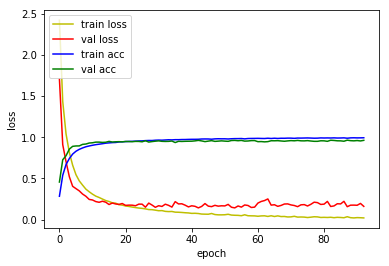

4815/4815 [==============================] - 3s 681us/sample - loss: 0.1873 - acc: 0.9452
Loss: 0.18727377580086144 Accuracy: 0.94517136

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1916 - acc: 0.3558
Epoch 00001: val_loss improved from inf to 1.12863, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_9_conv_checkpoint/001-1.1286.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 2.1916 - acc: 0.3558 - val_loss: 1.1286 - val_acc: 0.6587
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0659 - acc: 0.6612
Epoch 00002: val_loss improved from 1.12863 to 0.58095, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_BN_9_conv_checkpoint/002-0.5810.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.0658 - acc: 0.6613 - val_loss: 0.5810 - val_acc: 0.8348
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0905 - acc: 0.9720
Epoch 00024: val_loss did not improve from 0.12924
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0905 - acc: 0.9720 - val_loss: 0.1625 - val_acc: 0.9497
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0884 - acc: 0.9726
Epoch 00025: val_loss did not improve from 0.12924
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0884 - acc: 0.9726 - val_loss: 0.1313 - val_acc: 0.9611
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0780 - acc: 0.9759
Epoch 00026: val_loss did not improve from 0.12924
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0782 - acc: 0.9759 - val_loss: 0.1327 - val_acc: 0.9625
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9731
Epoch 00027: val_loss did not improve from 0.12924
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9880
Epoch 00054: val_loss did not improve from 0.12924
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0379 - acc: 0.9880 - val_loss: 0.1473 - val_acc: 0.9644
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9864
Epoch 00055: val_loss did not improve from 0.12924
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0423 - acc: 0.9864 - val_loss: 0.1389 - val_acc: 0.9651
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9939
Epoch 00056: val_loss did not improve from 0.12924
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0222 - acc: 0.9939 - val_loss: 0.1360 - val_acc: 0.9648
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9941
Epoch 00057: val_loss did not improve from 0.12924
36805/36805 [===========

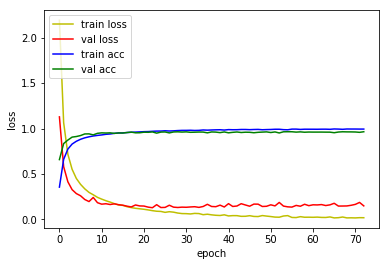

4815/4815 [==============================] - 3s 709us/sample - loss: 0.1752 - acc: 0.9458
Loss: 0.1752357086582595 Accuracy: 0.9457944



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_3_ch_32_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_3_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_ch_32_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 4s 743us/sample - loss: 0.4524 - acc: 0.8739
Loss: 0.4524365982224513 Accuracy: 0.87393564

1D_CNN_custom_3_ch_32_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_61 (Activation)   (

4815/4815 [==============================] - 4s 779us/sample - loss: 0.1873 - acc: 0.9452
Loss: 0.18727377580086144 Accuracy: 0.94517136

1D_CNN_custom_3_ch_32_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_76 (Activation)   

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_ch_32_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None

4815/4815 [==============================] - 4s 837us/sample - loss: 0.5498 - acc: 0.8712
Loss: 0.5498061100022938 Accuracy: 0.8712357

1D_CNN_custom_3_ch_32_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_61 (Activation)   (N

4815/4815 [==============================] - 4s 901us/sample - loss: 0.2000 - acc: 0.9502
Loss: 0.1999647291417805 Accuracy: 0.95015574

1D_CNN_custom_3_ch_32_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_76 (Activation)   (